In [7]:
import sys
sys.path.append('/Users/charleshiggins/Personal/CharlesPhD/CodeRepo/xai_intervention/RL-LRP/')
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import wandb
from experiments import DiffLrpWrapper, SimpleRNet, apply_threshold

# Initialize wandb
wandb.init(project="reverse_LRP_mnist", tags=["diff_lrp", "mnist", "simplernet"], mode="disabled")

# Load and transform the MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

# Initialize the network and optimizer for the underlying network
model = SimpleRNet()
optimizer = optim.Adam(model.parameters(), lr=1e-2)
# now wrap the network in the LRP class
wrapped_model = DiffLrpWrapper(model)
criterion = nn.MSELoss()

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
wrapped_model.to(device)

def test_inner_net(wrapped_model, device, test_loader):
    net = wrapped_model.net
    new_criterion = nn.CrossEntropyLoss()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            # target_map = apply_threshold(data)
            output = torch.nn.functional.softmax(net(data), dim=1)
            test_loss += new_criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    wandb.log({"Inner Network Loss": test_loss, "Inner Network Accuracy": accuracy})
    print(f'Inner Network Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%')
    return accuracy

# Function to test the model
def test(wrapped_model, device, test_loader):
    wrapped_model.eval()
    test_loss = 0
    correct = 0
    # with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        target_map = apply_threshold(data, threshold=0.9)
        output = wrapped_model(data, target.unsqueeze(1))
        test_loss += criterion(output, target_map).item()  # sum up batch loss
            # pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            # correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    # accuracy = 100. * correct / len(test_loader.dataset)
    wandb.log({"Test Loss": test_loss})
    underlying_network_accuracy = test_inner_net(wrapped_model, device, test_loader)
    return test_loss

# Training the model with early stopping
def train(wrapped_model, device, train_loader, optimizer, epoch, target_accuracy=99.0):
    wrapped_model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        target_map = apply_threshold(data, threshold=0.9)
        optimizer.zero_grad()
        # print(target.unsqueeze(1))
        output = wrapped_model(data, target.unsqueeze(1))
        loss = criterion(output, target_map)
        loss.backward()
        optimizer.step()
        
        wandb.log({"Train Loss": loss.item()})

        if batch_idx % 10 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
    
            accuracy = test(wrapped_model, device, test_loader)
            # wandb.log({"Test Accuracy": accuracy})
            # if accuracy >= target_accuracy:
            #     print(f"Stopping early: Reached {accuracy:.2f}% accuracy")
            #     return True
    return False

# Run training
for epoch in range(1, 11):  # 10
    if train(wrapped_model, device, train_loader, optimizer, epoch):
        break
    
wandb.finish()


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


reversing layer of type <class 'torch.nn.modules.linear.Linear'>
reversing layer of type <class 'torch.nn.modules.activation.ReLU'>
encounterted a ReLu Layer
reversing layer of type <class 'torch.nn.modules.linear.Linear'>
reversing layer of type <class 'torch.nn.modules.activation.ReLU'>
encounterted a ReLu Layer
reversing layer of type <class 'torch.nn.modules.conv.Conv2d'>
reversing layer of type <class 'torch.nn.modules.activation.ReLU'>
encounterted a ReLu Layer
reversing layer of type <class 'torch.nn.modules.conv.Conv2d'>
size of hooks dict: 7
Train Epoch: 1 [0/60000 (0%)]	Loss: 1.247748
reversing layer of type <class 'torch.nn.modules.linear.Linear'>
reversing layer of type <class 'torch.nn.modules.activation.ReLU'>
encounterted a ReLu Layer
reversing layer of type <class 'torch.nn.modules.linear.Linear'>
reversing layer of type <class 'torch.nn.modules.activation.ReLU'>
encounterted a ReLu Layer
reversing layer of type <class 'torch.nn.modules.conv.Conv2d'>
reversing layer of 

KeyboardInterrupt: 

/Users/charleshiggins/miniconda3/envs/minatar/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/charleshiggins/miniconda3/envs/minatar/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/charleshiggins/miniconda3/envs/minatar/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <E459C462-F863-3A5A-AC9F-FD77B14BE845> /Users/charleshiggins/miniconda3/envs/minatar/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


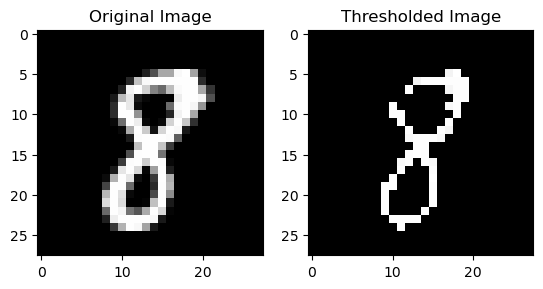

In [3]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

def load_mnist(batch_size=64):
    """ Load MNIST dataset with torchvision. """
    transform = transforms.Compose([
        transforms.ToTensor(),  # Converts to PyTorch tensors
        transforms.Normalize((0.5,), (0.5,))  # Normalizes the dataset
    ])
    
    train_set = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    return train_loader

def apply_threshold(images, threshold=0.5):
    """ Apply a threshold to the images, setting all pixels below the threshold to zero.
        Images should retain original dimensions.
    """
    # Thresholding
    thresholded_images = torch.where(images > threshold, images, torch.zeros_like(images))
    return thresholded_images


# Load data
train_loader = load_mnist(batch_size=10)

# Get a single batch of images
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Apply threshold
thresholded_images = apply_threshold(images, threshold=0.95)  # Using 0.5 as an example threshold

# Plotting
fig, axes = plt.subplots(1, 2)
axes[0].imshow(images[0][0], cmap='gray')
axes[0].set_title('Original Image')
axes[1].imshow(thresholded_images[0][0], cmap='gray')
axes[1].set_title('Thresholded Image')
plt.show()


In [4]:

images, labels = next(data_iter)
labels.shape

torch.Size([10])

In [5]:
outputs = wrapped_model(images, labels.unsqueeze(1))

NameError: name 'wrapped_model' is not defined

NameError: name 'outputs' is not defined

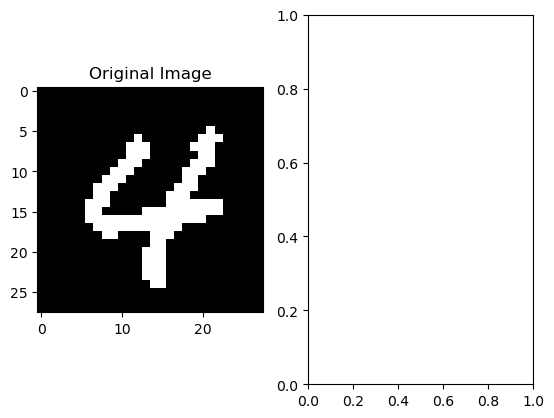

In [6]:
# Plotting
fig, axes = plt.subplots(1, 2)
axes[0].imshow(apply_threshold(images)[0][0], cmap='gray')
axes[0].set_title('Original Image')
axes[1].imshow(outputs.detach()[0][0], cmap='hot')
axes[1].set_title('Output Image')
plt.colorbar()
plt.show()


In [20]:
outputs.detach()[0][0]

tensor([[ 6.3141e-03,  1.9478e-02,  3.9422e-02,  6.4557e-02,  9.5678e-02,
          1.2046e-01,  1.3839e-01,  1.4954e-01,  1.5549e-01,  1.5543e-01,
          1.5542e-01,  1.5544e-01,  1.5549e-01,  1.5557e-01,  1.5566e-01,
          1.5574e-01,  1.5583e-01,  1.5591e-01,  1.5600e-01,  1.5609e-01,
          1.4983e-01,  1.3669e-01,  1.1673e-01,  9.1522e-02,  6.0278e-02,
          3.5365e-02,  1.7309e-02,  6.0384e-03],
        [ 1.8260e-02,  5.7282e-02,  1.1568e-01,  1.9048e-01,  2.8327e-01,
          3.5775e-01,  4.1143e-01,  4.4572e-01,  4.6358e-01,  4.6343e-01,
          4.6338e-01,  4.6344e-01,  4.6357e-01,  4.6377e-01,  4.3467e-01,
          4.0091e-01,  3.6685e-01,  3.7185e-01,  4.0034e-01,  4.3487e-01,
          4.4138e-01,  4.0818e-01,  3.4975e-01,  2.7475e-01,  1.8163e-01,
          1.0680e-01,  5.2755e-02,  1.8125e-02],
        [ 3.6553e-02,  1.1452e-01,  2.3011e-01,  3.7993e-01,  5.6400e-01,
          7.1142e-01,  8.1734e-01,  8.8556e-01,  9.1954e-01,  9.1928e-01,
          9.19

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CosineDistanceLoss(nn.Module):
    def __init__(self):
        super(CosineDistanceLoss, self).__init__()

    def forward(self, input1, input2):
        # Flatten the images: shape from [b, 1, 28, 28] to [b, 784]
        input1_flat = input1.view(input1.size(0), -1)
        input2_flat = input2.view(input2.size(0), -1)
        
        # Compute cosine similarity, then convert to cosine distance
        cosine_sim = F.cosine_similarity(input1_flat, input2_flat)
        cosine_dist = 1 - cosine_sim
        
        # Calculate the mean of the cosine distances
        loss = cosine_dist.mean()
        return loss

# Example usage
if __name__ == "__main__":
    # Random tensors simulating image batches
    img1 = torch.randn(10, 1, 28, 28)  # Batch of 10 images
    img2 = torch.randn(10, 1, 28, 28)  # Batch of 10 images
    
    # Initialize the loss function
    loss_func = CosineDistanceLoss()
    
    # Calculate loss
    loss = loss_func(img1, img2)
    print("Cosine Distance Loss:", loss.item())


Cosine Distance Loss: 1.0005197525024414
